# Проект
Данный проект нацелен на анализ вакансий от работодателей финансового сектора на сайте hh.ru
С целью сбора данных был написан специальный парсер (parser.ipynb)
В данном ноутбуке используется спарсенная заранее таблица с данными.

### Импорт библиотек

In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### Чтение датасета и предварительная обработка
Посмотрим как выглядят данные, удалим ненужные колонки, заполним NaN значения, преобразуем данные.
Начнём с чтения датасета. Так же посмотрим как он вообще выглядит.

In [2]:
df = pd.read_csv('fin-sec_15_05_2023.csv')
df.head()

,Unnamed: 0,id,premium,name,department,has_test,response_letter_required,area,salary,type,...,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment
0,0,79757064,False,Бухгалтер,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 60000, 'to': 60000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,[],[],[],False,"[{'id': '18', 'name': 'Бухгалтер'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
1,1,80165021,False,Делопроизводитель,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 70000, 'to': 70000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,[],[],[],False,"[{'id': '33', 'name': 'Делопроизводитель, архи...",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
2,2,80434995,False,Курьер,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 38000, 'to': 40000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,[],[],[],False,"[{'id': '58', 'name': 'Курьер'}]",True,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
3,3,78193179,False,Менеджер по работе с клиентами,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 52000, 'to': 52000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,[],[],[],False,"[{'id': '70', 'name': 'Менеджер по продажам, м...",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
4,4,80351513,False,Помощник по хозяйству в Крым,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 90000, 'to': 110000, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",...,NaN,NaN,[],[],[],False,"[{'id': '90', 'name': 'Охранник'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"


Давайте посмотрим что вообще находится внутри датасета и сколько уникальных данных в колонках.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 2000 non-null   int64  
 1   id                         2000 non-null   int64  
 2   premium                    2000 non-null   bool   
 3   name                       2000 non-null   object 
 4   department                 285 non-null    object 
 5   has_test                   2000 non-null   bool   
 6   response_letter_required   2000 non-null   bool   
 7   area                       2000 non-null   object 
 8   salary                     2000 non-null   object 
 9   type                       2000 non-null   object 
 10  address                    1387 non-null   object 
 11  response_url               0 non-null      float64
 12  sort_point_distance        0 non-null      float64
 13  published_at               2000 non-null   objec

В результате у нас обнаружилось 34 колонки с индексами от 0 до 33 и 2000 записей.
Важно отметить, что все 2000 записей валидны, так как благодаря выставленным при парсинге параметрам каждая вакансия, а соответственно и запись, имеет необходимые нам данные.

**Колонка 0 (Unnamed: 0)** содержит порядковый индекс вакансии, тип данных целочисленный.
**Колонка 1 (id)** содержит уникальный id вакансии, тип данных целочисленный.
**Колонка 2 (premium)** указывает на наличие оплаченной рекламной позиции, тип данных булевый.
**Колонка 3 (name)** содержит название вакансии, тип данных object (внутри вложена строка).
**Колонка 4 (department)** содержит данные о департаменте работодателя, тип данных object (внутри вложен словарь).
**Колонка 5 (has_test)** указывает на наличие теста внутри системы hh.ru, тип данных булевый.
**Колонка 6 (response_letter_required)** содержит данные о необходимости прикрепить сопроводительное письмо, тип данных булевый.
**Колонка 7 (area)** содержит данные о регионе, тип данных целочисленный.
**Колонка 8 (salary)** содержит данные о зарплате, валюте и гросс, тип данных object (внутри вложен словарь).
**Колонка 9 (type)** указывает на анонимность или публичность вакансии, тип данных object (внутри вложен словарь).
**Колонка 10 (address)** содержит данные об адрессе работодателя, тип данных object (внутри вложен словарь).
**Колонка 11 (response_url)** не совсем понятна функция колонки, тип данных float64, но на деле содержит только NaN.
**Колонка 12 (sort_point_distance)** не совсем понятна функция колонки, тип данных float64, но на деле содержит только NaN.
**Колонка 13 (published_at)** содержит данные о дате и времени публикации, тип данных object (внутри вложен datetime).
**Колонка 14 (created_at)** содержит данные о дате и времени создании, тип данных object (внутри вложен datetime).
**Колонка 15 (archived)** указывает на архивацию вакансии, тип данных булевый.
**Колонка 16 (apply_alternate_url)** содержит ссылку для отклика на вакансию, тип данных object (внутри вложена строка).
**Колонка 17 (insider_interview)** содержит ссылку для интервью с сотрудинками, тип данных object (внутри вложен словарь).
**Колонка 18 (url)** содержит ссылку на вакансию, тип данных object (внутри вложена строка).
**Колонка 19 (adv_response_url)** не совсем понятна функция колонки, тип данных float64, но на деле содержит только NaN.
**Колонка 20 (alternate_url)** содержит короткую ссылку на вакансию, тип данных object (внутри вложена строка).
**Колонка 21 (relations)** не совсем понятна функция колонки, тип данных object, но на деле содержит только пустой список.
**Колонка 22 (employer)** содержит данные о работодателе, тип данных оbject (внутри вложен словарь).
**Колонка 23 (snippet)** по сути своей содержит описание вакансии, тип данных object (внутри вложен словарь).
**Колонка 24 (contacts)** не совсем понятна функция колонки, тип данных float64, но на деле содержит только NaN.
**Колонка 25 (schedule)** не совсем понятна функция колонки, тип данных float64, но на деле содержит только NaN.
**Колонка 26 (working_days)** содержит данные о работе по выходным, тип данных object (внутри вложен лист со словарём).
**Колонка 27 (working_time_intervals)** содержит данные о работе в неполный рабочий день, тип данных object (внутри вложен лист со словарём).
**Колонка 28 (working_time_modes)** содержит данные о возможном времмени начала рабочего дня, тип данных object (внутри вложен лист со словарём).
**Колонка 29 (accept_temporary)** указывает на временное трудоустройство, тип данных булевый.
**Колонка 30 (professional_roles)** сожержит данные о профессии вакансии, тип данных object (внутри вложен лист со словарём).
**Колонка 31 (accept_incomplete_resumes)** указывает на возможность отклика с неполным или без резюме, тип данных булевый.
**Колонка 32 (experience)** содержит данные о требуемом опыте, тип данных object (внутри вложен словарь).
**Колонка 33 (employment)** содержит данные о типе занятости, тип данных object (внутри вложен словарь).

Из важного на данном этапе:
Колонки **department**, **insider_interview** содержат слишком мало данных для работы с ними.

Колонки **response_url**, **sort_point_distance**, **adv_response_url**, **contacts** и **schedule** пустые.

Среди данных, которые нам не нужны имеем следующее:
**Unnamed: 0** - всё равно, что индекс.
**Premium** - не несёт практической пользы для анализа.
**Name** - необъективная информация.
**Area** - у нас и так только один регион.
**Type** - не несёт практической пользы для анализа.
**Address** - не несёт практической пользы для анализа.
**Published_at** - не несёт практической пользы для анализа.
**Created_at** - не несёт практической пользы для анализа.
**Archived** - не несёт практической пользы для анализа.
**Apply_alternate_url** - не несёт практической пользы для анализа.
**Url** - не несёт практической пользы для анализа.
**Alternate_url** - не несёт практической пользы для анализа.
**Relations** - не несёт практической пользы для анализа.
**Employer** - не несёт практической пользы для анализа.
**Snippet** - необъективная информация.
**Working_days** - неполные и/или нерелевантные данные.
**Working_time_intervals** - неполные и/или нерелевантные данные.
**Working_time_modes** - неполные и/или нерелевантные данные.

Соберём все выше указанные колонки в список и удалим.

In [4]:
list_for_deletion = ['department', 'insider_interview', 'response_url', 'sort_point_distance', 'adv_response_url', 'contacts', 'schedule', 'Unnamed: 0', 'premium', 'name', 'area', 'type', 'address', 'published_at', 'created_at', 'archived', 'apply_alternate_url', 'url', 'alternate_url', 'relations', 'employer', 'snippet', 'working_days', 'working_time_intervals', 'working_time_modes']

df.drop(list_for_deletion, axis=1, inplace=True)
df.head()

,id,has_test,response_letter_required,salary,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment
0,79757064,False,False,"{'from': 60000, 'to': 60000, 'currency': 'RUR'...",False,"[{'id': '18', 'name': 'Бухгалтер'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
1,80165021,False,False,"{'from': 70000, 'to': 70000, 'currency': 'RUR'...",False,"[{'id': '33', 'name': 'Делопроизводитель, архи...",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
2,80434995,False,False,"{'from': 38000, 'to': 40000, 'currency': 'RUR'...",False,"[{'id': '58', 'name': 'Курьер'}]",True,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
3,78193179,False,False,"{'from': 52000, 'to': 52000, 'currency': 'RUR'...",False,"[{'id': '70', 'name': 'Менеджер по продажам, м...",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
4,80351513,False,False,"{'from': 90000, 'to': 110000, 'currency': 'RUR...",False,"[{'id': '90', 'name': 'Охранник'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"


В данном случае id вакансии уникальное значение, потому мы можем сделать её индексом.

In [5]:
df.set_index('id', inplace=True, drop=True)
df.head()

,has_test,response_letter_required,salary,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment
id,,,,,,,,
79757064,False,False,"{'from': 60000, 'to': 60000, 'currency': 'RUR'...",False,"[{'id': '18', 'name': 'Бухгалтер'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
80165021,False,False,"{'from': 70000, 'to': 70000, 'currency': 'RUR'...",False,"[{'id': '33', 'name': 'Делопроизводитель, архи...",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
80434995,False,False,"{'from': 38000, 'to': 40000, 'currency': 'RUR'...",False,"[{'id': '58', 'name': 'Курьер'}]",True,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
78193179,False,False,"{'from': 52000, 'to': 52000, 'currency': 'RUR'...",False,"[{'id': '70', 'name': 'Менеджер по продажам, м...",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
80351513,False,False,"{'from': 90000, 'to': 110000, 'currency': 'RUR...",False,"[{'id': '90', 'name': 'Охранник'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"


Важно заметить, что колонки salary, professional_role, experience и employment представлены в виде словарей.
Эти данные необходимо вытащить из словаря.

In [6]:
# Зарплата
df["salary"] =  df["salary"].map(lambda d : ast.literal_eval(d))
df_buffer = df.join(pd.DataFrame(df["salary"].to_dict()).T)
df_buffer = df_buffer.fillna(value=np.nan)  # Не у всех вакансий есть минимальная и максимальная зарплата

In [7]:
df = df_buffer[['has_test', 'response_letter_required', 'accept_temporary', 'professional_roles', 'accept_incomplete_resumes', 'experience', 'employment', 'from', 'to', 'currency', 'gross']]
df.head()

,has_test,response_letter_required,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,from,to,currency,gross
id,,,,,,,,,,,
38132918,False,False,False,"[{'id': '40', 'name': 'Другое'}]",True,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",60000.0,NaN,RUR,False
38399506,False,False,False,"[{'id': '40', 'name': 'Другое'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",127650.0,NaN,RUR,True
38886931,False,False,False,"[{'id': '40', 'name': 'Другое'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",150000.0,500000.0,RUR,True
40118299,False,False,False,"[{'id': '119', 'name': 'Специалист по тендерам'}]",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",80000.0,NaN,RUR,False
40281646,False,False,False,"[{'id': '40', 'name': 'Другое'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",200000.0,400000.0,RUR,False


Поскольку мы не можем заполнить отсутствующие значения from и to без нарушения логики датасета с помощью среднего или медианы (когда у вакансий минимальная может быть выше максимальной и т.п.), то заполним эти две колонки в одну следующим образом:
Если указана только минимальная, то устанавливаем её и как максимальную.
Если указана только максимальная, то устанавливаем её и как минимальную.

Мы сделаем это так же по той причине, что настоящий потолок и минимум дохода отличается от работодателя к работодателю, потому брать в таких случаях минимум и максимум по сфере не корректно и может испортить данные.

In [8]:
df['to'] = df['to'].fillna(df['from'])
df['from'] = df['from'].fillna(df['to'])
df.head()

,has_test,response_letter_required,accept_temporary,professional_roles,accept_incomplete_resumes,experience,employment,from,to,currency,gross
id,,,,,,,,,,,
38132918,False,False,False,"[{'id': '40', 'name': 'Другое'}]",True,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",60000.0,60000.0,RUR,False
38399506,False,False,False,"[{'id': '40', 'name': 'Другое'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",127650.0,127650.0,RUR,True
38886931,False,False,False,"[{'id': '40', 'name': 'Другое'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",150000.0,500000.0,RUR,True
40118299,False,False,False,"[{'id': '119', 'name': 'Специалист по тендерам'}]",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}",80000.0,80000.0,RUR,False
40281646,False,False,False,"[{'id': '40', 'name': 'Другое'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}",200000.0,400000.0,RUR,False


In [9]:
# Профессия
df['professional_roles'] =  df['professional_roles'].map(lambda d : ast.literal_eval(d))

dict_buff = df['professional_roles'].to_dict()
for key in dict_buff:
    dict_buff[key] = dict(name = dict_buff[key][0]['name'])

df_buffer = df.join(pd.DataFrame(dict_buff).T)

In [10]:
df = df_buffer[['name', 'from', 'to', 'currency', 'gross', 'has_test', 'response_letter_required', 'accept_temporary', 'accept_incomplete_resumes', 'experience', 'employment']]
df.head()

,name,from,to,currency,gross,has_test,response_letter_required,accept_temporary,accept_incomplete_resumes,experience,employment
38132918,Другое,60000.0,60000.0,RUR,False,False,False,False,True,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
38399506,Другое,127650.0,127650.0,RUR,True,False,False,False,False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
38886931,Другое,150000.0,500000.0,RUR,True,False,False,False,False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"
40118299,Специалист по тендерам,80000.0,80000.0,RUR,False,False,False,False,False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'full', 'name': 'Полная занятость'}"
40281646,Другое,200000.0,400000.0,RUR,False,False,False,False,False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}"


In [11]:
# Опыт
df['experience'] =  df['experience'].map(lambda d : ast.literal_eval(d))

dict_buff = df['experience'].to_dict()
for key in dict_buff:
    dict_buff[key] = dict(exp_buff = dict_buff[key]['name'])

df_buffer = df.join(pd.DataFrame(dict_buff).T)

In [12]:
df = df_buffer[['name', 'from', 'to', 'currency', 'gross', 'has_test', 'response_letter_required', 'accept_temporary', 'accept_incomplete_resumes', 'exp_buff', 'employment']]
df.rename(columns={'exp_buff': 'experience'}, inplace=True)
df.head()

,name,from,to,currency,gross,has_test,response_letter_required,accept_temporary,accept_incomplete_resumes,experience,employment
38132918,Другое,60000.0,60000.0,RUR,False,False,False,False,True,От 1 года до 3 лет,"{'id': 'full', 'name': 'Полная занятость'}"
38399506,Другое,127650.0,127650.0,RUR,True,False,False,False,False,От 1 года до 3 лет,"{'id': 'full', 'name': 'Полная занятость'}"
38886931,Другое,150000.0,500000.0,RUR,True,False,False,False,False,От 1 года до 3 лет,"{'id': 'full', 'name': 'Полная занятость'}"
40118299,Специалист по тендерам,80000.0,80000.0,RUR,False,False,False,False,False,Нет опыта,"{'id': 'full', 'name': 'Полная занятость'}"
40281646,Другое,200000.0,400000.0,RUR,False,False,False,False,False,От 1 года до 3 лет,"{'id': 'full', 'name': 'Полная занятость'}"


In [13]:
# Тип занятости
df['employment'] =  df['employment'].map(lambda d : ast.literal_eval(d))

dict_buff = df['employment'].to_dict()
for key in dict_buff:
    dict_buff[key] = dict(emp_buff = dict_buff[key]['name'])

df_buffer = df.join(pd.DataFrame(dict_buff).T)

In [14]:
df = df_buffer[['name', 'from', 'to', 'currency', 'gross', 'has_test', 'response_letter_required', 'accept_temporary', 'accept_incomplete_resumes', 'experience', 'emp_buff']]
df.rename(columns={'emp_buff': 'employment'}, inplace=True)
df.head()

,name,from,to,currency,gross,has_test,response_letter_required,accept_temporary,accept_incomplete_resumes,experience,employment
38132918,Другое,60000.0,60000.0,RUR,False,False,False,False,True,От 1 года до 3 лет,Полная занятость
38399506,Другое,127650.0,127650.0,RUR,True,False,False,False,False,От 1 года до 3 лет,Полная занятость
38886931,Другое,150000.0,500000.0,RUR,True,False,False,False,False,От 1 года до 3 лет,Полная занятость
40118299,Специалист по тендерам,80000.0,80000.0,RUR,False,False,False,False,False,Нет опыта,Полная занятость
40281646,Другое,200000.0,400000.0,RUR,False,False,False,False,False,От 1 года до 3 лет,Полная занятость


Так же, что стоит сделать это закодировать все True и False значения в числовой вариант 1 и 0, для простоты работы в будущем.

In [15]:
df['gross'] = np.where(df['gross'] == False, 0, 1)
df['has_test'] = np.where(df['has_test'] == False, 0, 1)
df['response_letter_required'] = np.where(df['response_letter_required'] == False, 0, 1)
df['accept_temporary'] = np.where(df['accept_temporary'] == False, 0, 1)
df['accept_incomplete_resumes'] = np.where(df['accept_incomplete_resumes'] == False, 0, 1)
df.head()

,name,from,to,currency,gross,has_test,response_letter_required,accept_temporary,accept_incomplete_resumes,experience,employment
38132918,Другое,60000.0,60000.0,RUR,0,0,0,0,1,От 1 года до 3 лет,Полная занятость
38399506,Другое,127650.0,127650.0,RUR,1,0,0,0,0,От 1 года до 3 лет,Полная занятость
38886931,Другое,150000.0,500000.0,RUR,1,0,0,0,0,От 1 года до 3 лет,Полная занятость
40118299,Специалист по тендерам,80000.0,80000.0,RUR,0,0,0,0,0,Нет опыта,Полная занятость
40281646,Другое,200000.0,400000.0,RUR,0,0,0,0,0,От 1 года до 3 лет,Полная занятость


Теперь давайте приведём данные по зарплатам к единой валюте. Для того, что бы было легче понимать суммы и их значимость приведём всё к рублю.
В качестве курса буде твзят официальный крус ЦБ РФ на 30.05.2023 и окрулим до ближайшего целого:
1 USD = 80.0555 RUB -> 1 USD = 80 RUB

Чтобы убедиться, что тип валюты не особо нам интересен убедимся в том, что иностранная валюта составляет малую часть выборки.

In [16]:
df.currency.value_counts()

currency
RUR    1986
USD      14
Name: count, dtype: int64

Всего 14 записей. Эти данные едва ли покажут нам какую-то закономерность.
Потому переведём их в рубли.
А за одно и посчитаем среднее значение, это будет полезно в будущем.

In [17]:
df['from'] = np.where(df['currency'] == 'USD', df['from'] * 80, df['from'])
df['to'] = np.where(df['currency'] == 'USD', df['from'] * 80, df['from'])
df.drop(['currency'], axis=1, inplace=True)
df['mean'] = (df['from'] + df['to']) / 2
df.head()

,name,from,to,gross,has_test,response_letter_required,accept_temporary,accept_incomplete_resumes,experience,employment,mean
38132918,Другое,60000.0,60000.0,0,0,0,0,1,От 1 года до 3 лет,Полная занятость,60000.0
38399506,Другое,127650.0,127650.0,1,0,0,0,0,От 1 года до 3 лет,Полная занятость,127650.0
38886931,Другое,150000.0,150000.0,1,0,0,0,0,От 1 года до 3 лет,Полная занятость,150000.0
40118299,Специалист по тендерам,80000.0,80000.0,0,0,0,0,0,Нет опыта,Полная занятость,80000.0
40281646,Другое,200000.0,200000.0,0,0,0,0,0,От 1 года до 3 лет,Полная занятость,200000.0


Теперь закодируем опыт и тип занятости следующим образом:
Нет опыта - 0
Опыт от 1 года до 3 лет - 1
Опыт от 3 до 6 лет - 3
Более 6 лет - 6

Проектная работа - 0
Стажировка - 1
Частичная занятость - 2
Полная занятость - 3

In [18]:
df['experience'] = np.where(df['experience'] == 'Нет опыта', 0, df['experience'])
df['experience'] = np.where(df['experience'] == 'От 1 года до 3 лет', 1, df['experience'])
df['experience'] = np.where(df['experience'] == 'От 3 до 6 лет', 3, df['experience'])
df['experience'] = np.where(df['experience'] == 'Более 6 лет', 6, df['experience'])

In [19]:
df['employment'] = np.where(df['employment'] == 'Проектная работа', 0, df['employment'])
df['employment'] = np.where(df['employment'] == 'Стажировка', 1, df['employment'])
df['employment'] = np.where(df['employment'] == 'Частичная занятость', 2, df['employment'])
df['employment'] = np.where(df['employment'] == 'Полная занятость', 3, df['employment'])

In [20]:
df.head()

,name,from,to,gross,has_test,response_letter_required,accept_temporary,accept_incomplete_resumes,experience,employment,mean
38132918,Другое,60000.0,60000.0,0,0,0,0,1,1,3,60000.0
38399506,Другое,127650.0,127650.0,1,0,0,0,0,1,3,127650.0
38886931,Другое,150000.0,150000.0,1,0,0,0,0,1,3,150000.0
40118299,Специалист по тендерам,80000.0,80000.0,0,0,0,0,0,0,3,80000.0
40281646,Другое,200000.0,200000.0,0,0,0,0,0,1,3,200000.0


Может показаться, что на этом с обработкой мы закончили, однако вакансия со специализацией "Другое" говорит очень мало. Потому все подобные вакансии мы удалим.

In [21]:
df.drop(df[df.name == 'Другое'].index, inplace=True)
df.head()

,name,from,to,gross,has_test,response_letter_required,accept_temporary,accept_incomplete_resumes,experience,employment,mean
40118299,Специалист по тендерам,80000.0,80000.0,0,0,0,0,0,0,3,80000.0
45736889,"Менеджер по продажам, менеджер по работе с кли...",80000.0,80000.0,0,0,0,0,0,0,3,80000.0
45868600,Руководитель отдела продаж,200000.0,200000.0,1,0,0,0,0,1,3,200000.0
46015114,Агент по недвижимости,100000.0,100000.0,1,0,0,0,0,0,3,100000.0
46075211,Страховой агент,50000.0,50000.0,0,0,0,0,0,0,2,50000.0


На этом этапе с обработкой датасета мы закончили, давайте посмотрим на то, что осталось.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1770 entries, 40118299 to 80457454
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       1770 non-null   object 
 1   from                       1770 non-null   float64
 2   to                         1770 non-null   float64
 3   gross                      1770 non-null   int32  
 4   has_test                   1770 non-null   int32  
 5   response_letter_required   1770 non-null   int32  
 6   accept_temporary           1770 non-null   int32  
 7   accept_incomplete_resumes  1770 non-null   int32  
 8   experience                 1770 non-null   object 
 9   employment                 1770 non-null   object 
 10  mean                       1770 non-null   float64
dtypes: float64(3), int32(5), object(3)
memory usage: 131.4+ KB


В результате у нас осталось 10 колонок с индексами от 0 до 9 и 1770 записей.

**Колонка 0 (name)** содержит данные о специальности, тип данных object (внутри вложена строка).
**Колонка 1 (from)** содержит данные о минимальной заработной плате, тип данных float64.
**Колонка 2 (to)** содержит данные о максимальной заработной плате, тип данных float64.
**Колонка 3 (gross)** содержит данные о том, указана ли зарплата до вычета налогов, тип данных целочисленный.
**Колонка 4 (has_test)** содержит данные о том, требуется ли проходить тест в системе hh.ru, тип данных целочисленный.
**Колонка 5 (response_letter_required)** содержит данные о том, требуется ли приложить сопроводительное письмо, тип данных целочисленный.
**Колонка 6 (accept_temporary)** содержит данные о том, является ли работа временной, тип целочисленный.
**Колонка 7 (accept_incomplete_resumes)** содержит данные о том, принимаются ли отклики без или с неполными резюме, тип данных целочисленный.
**Колонка 8 (expirience)** содержит данные о том, какой опыт требуется работодателю, тип данных целочисленный.
**Колонка 9 (employment)** содержит данные о типе занятости, тип данных целочисленный.

### Визуализация и EDA

Прежде всего следует узнать количествво и разнообразие прфоессий в нашем датасете, это важно для более полного понимания картины и дальнейшего анализа нашего датасета.

In [23]:
professions = df['name'].value_counts()
professions[0:13]

name
Менеджер по продажам, менеджер по работе с клиентами    459
Бухгалтер                                                91
Кредитный специалист                                     91
Оператор call-центра, специалист контактного центра      66
Секретарь, помощник руководителя, ассистент              52
Делопроизводитель, архивариус                            50
Кассир-операционист                                      44
Программист, разработчик                                 42
Специалист по подбору персонала                          36
Финансовый менеджер                                      31
Аналитик                                                 31
Юрисконсульт                                             31
Специалист технической поддержки                         30
Name: count, dtype: int64

У нас вышло 130 профессий.
Можем визуализировать первые 9 из них, а все остальные загнать в "Другое"
То есть, всего будет вывведено 10 типов.

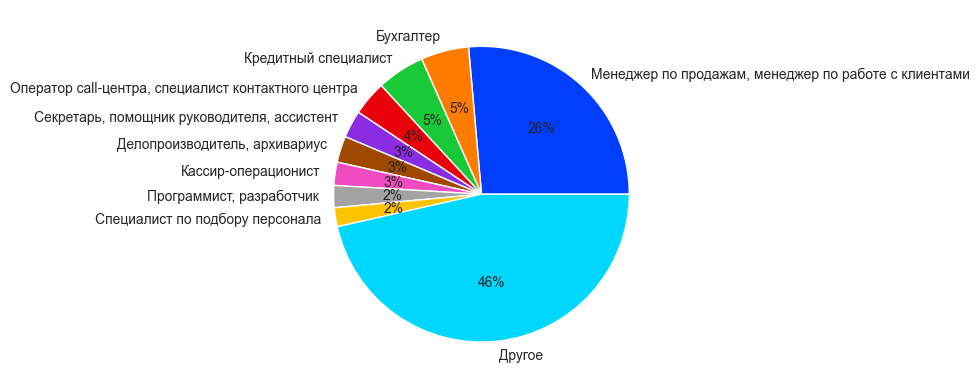

In [24]:
keys = professions.head(9).keys().tolist()
keys.append('Другое')
data = [459/1770, 91/1770, 91/1770, 66/1770, 52/1770, 50/1770, 44/1770, 42/1770, 36/1770, 808/1770]

palette_color = sns.color_palette('bright')
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
plt.show()

Прямо сейчас мы можем увидеть неприятную особенность нашего датасета.
Большая часть профессий имеет очень малое количество вакансий, настолько, что топ-9 первых состовляют всего половину датасета.

И в рамках таких сложных условий, менеджер по продажам и/или работе с клиентами занимает 26% нашей выборки.
Это может иметь сильные последствие в процессе машинного обучения, поскольку модель может значительно перекосить в сторону именно данной должности.

Так же может показаться хорошей идеей сделать гистограммы и ящики с усами для зарплат в целом, зарплат менеджеров по продажам и/или работе с клиентами и всех зарплат без менеджеров по продажам и/или работе с клиентами.
Однако распределение слишком ненормальное, так же имеются выбросы и потому любая попытка ввизуализации ввв вввиде гистограм или ящика с усами, из предпринятых нами, имела крайне неудовлетворительный результат. Потому нам просто придётся иметь ввиду, что данные очень неравномерны и имеют ненормальное распределение.

Продолжим анализировать то, что у нас есть сейчас. Уже на данном этапе из-за турдностей с попыткой выведения гистограммы можно понять, что распределение данных не является нормальным.
Важно отметить, что часть данных у нас ранговые, другая часть линейные, а так же присутствуют бинарные данные.
Поскольку корреляция Пирсона, в внашем случае, будет полезна исключительно для данных о зарплате, то более логичным выглядит использовать ранговую корреляцию Спирмена, а корреляцию зарплат между собой проверить отдельно, с помощью корреляции Пирсона.

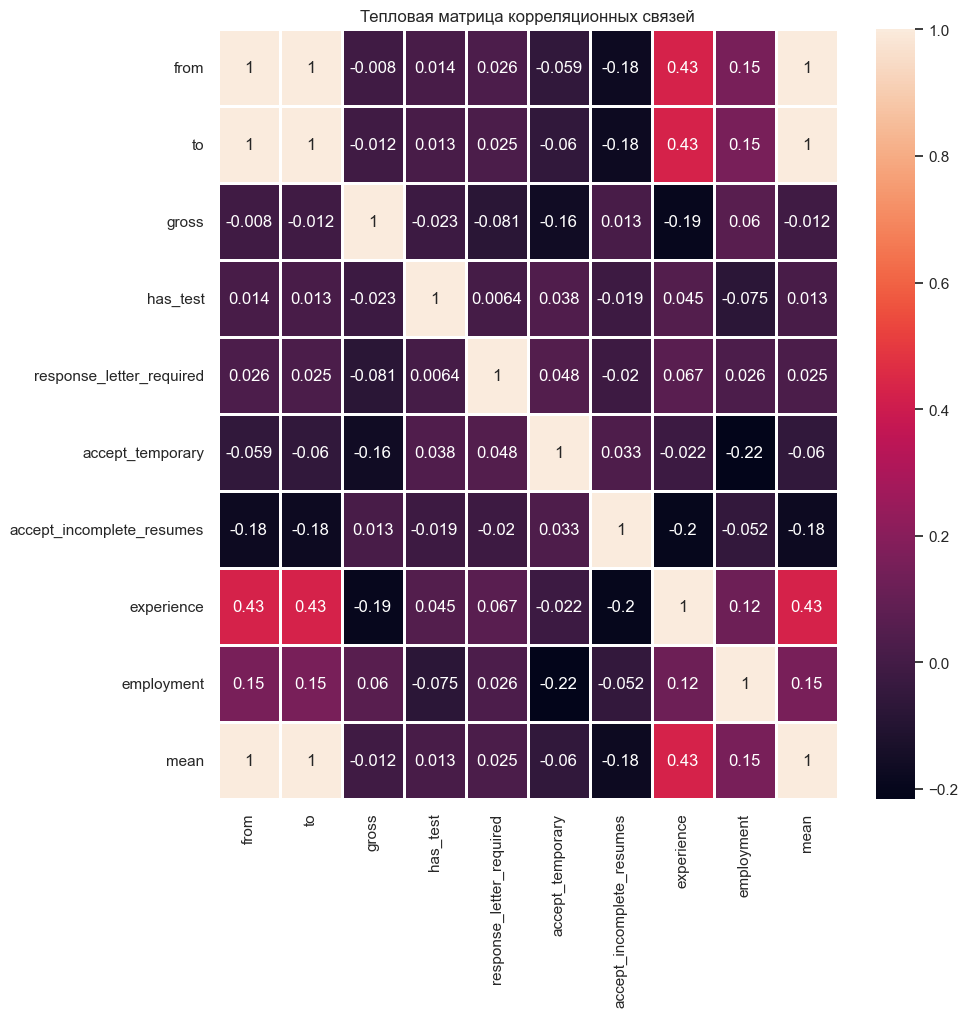

In [25]:
df_corr = df.loc[:, df.columns!='name'].corr(method='spearman')
sns.set_theme()

f, ax = plt.subplots(figsize=(10, 10))
plt.title('Тепловая матрица корреляционных связей')
sns.heatmap(df_corr, annot=True, linewidths=1, ax=ax);

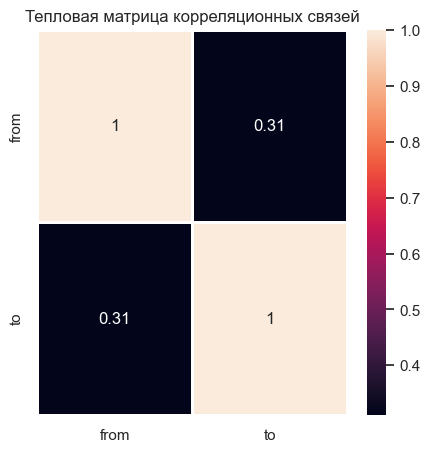

In [26]:
df_corr = df[['from', 'to']].corr(method='pearson')
sns.set_theme()

f, ax = plt.subplots(figsize=(5, 5))
plt.title('Тепловая матрица корреляционных связей')
sns.heatmap(df_corr, annot=True, linewidths=1, ax=ax);

Исходя из полученной информации, мы можем заметить положительную корреляцию между минимальной и максимальной заработной платой, но не стоит забывать, что это может быть вызвано обработкой датасета, в которой мы приравняли минимальное и максимальное в тех местах, в которых было указано только одно из двух. А так в целом как корреляция Пирсона, так Спирмена показала достаточно логичную связь, которую можно интерпретировать как "Чем выше минимальный доход на позиции, тем выше и максимальный". Однако проверять эту гипотезу мы не будем ввиду нашего вмешательства в данные.

Корреляция между большинстввом данных минимальная, что может быть вызвано нехваткой данных с нужными признаками вв нашей выборке. Однако есть и две интересные закономерности:
1. Опыт положительно влияет на доходы соискателя.
2. Работа с полной занятостью значительно реже является временной, в отличие от проектной работы и стажировок.

Помимо двух указанных есть и две менее явные закономерности:
1. Работа с полной занятостью чаще предлагает более высокий доход.
2. Работа с полной занятостью чаще требует наличие опыта.

Эти 4 закономерности будут сформулированы в гипотезы и проверны далее с помощью математических методов.

### Формулироввка и проверка гипотез

#### Гипотеза 1

Начнём с формулировки и проверки первой закономерности, а именно что опыт влияет на зарплату. Идея следующая: если зарплаты окажутся не равны, то тогда самое логическое объяснение, что опыт положительно влияет на доход (корреляция всё же была положительной).
u1 = средний доход по ввакансиям без опыта
u2 = средний доход по вакансиям с опытом более 3-х лет
Н0: u1 == u2
Н1: u1 < u2

In [27]:
# Соберём эти данные и посмотрим на их размер
u1 = df[df.experience == 3]['mean'].tolist()
u2 = df[df.experience == 0]['mean'].tolist()
print(f'Длинна u1: {len(u1)}')
print(f'Длинна u2: {len(u2)}')

Длинна u1: 350
Длинна u2: 525


In [28]:
# Поскольку выборка исчисляется сотнями, то проверим их на нормальность (Хотя ответ почти очевиден) с помощью теста Шапиро-Уилка
stat1, p1 = scipy.stats.shapiro(u1)
stat2, p2 = scipy.stats.shapiro(u2)

if p1 < 0.05:
    print(f'Результат: {p1}')
    print('u1 ненормально распределено.')
if p2 < 0.05:
    print(f'Результат: {p2}')
    print('u2 ненормально распределено.')

Результат: 6.142761992053343e-37
u1 ненормально распределено.
Результат: 1.401298464324817e-44
u2 ненормально распределено.


In [29]:
# Поскольку распределение ненормальное, проведём тест Левена на дисперсию.

test, p = scipy.stats.levene(u1, u2)

if p < 0.05:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Отклонить гипотезу о равенстве дисперсий


В таких условиях лучше использовать непараметрический тест, поскольку дисперсии различны а данные не имеют распределения Гаусса. В данный момент хорошим решенеим кажется провести Kruskal-Wallis H Test на всех четырёх категориях опыта по их зарплатам, в таком случае мы поменяем гипотезу.

Выбор этого теста вызван тем, что нам удобнее проверить равенство всех четырёх независимых, ненормально распределённых выборок и данный тест с данной задачей справляется.

u1 = средний доход по вакансиям без опыта
u2 = средний доход по вакансиям с опытом более года
u3 = средний доход по вакансиям с опытом более 3-х лет
u4 = средний доход по вакансиям с опытом более 6-ти лет

Н0: u1 == u2 == u3 == u4

Посольку корреляция показала, что зависисмость положительная, а так же благодаря логике, мы будем считать, что альтернативная гипотеза говорит не просто о неравенстве, но о размерности доходов.

Н1: u1 < u2 < u3 < u4

In [30]:
u1 = df[df.experience == 0]['mean'].tolist()
u2 = df[df.experience == 1]['mean'].tolist()
u3 = df[df.experience == 3]['mean'].tolist()
u4 = df[df.experience == 6]['mean'].tolist()

stat, p = scipy.stats.kruskal(u1, u2, u3, u4)
if p < 0.05:
    print('Отклонить гипотезу о равенстве доходов')
else:
    print('Принять гипотезу о равенстве доходов')

Отклонить гипотезу о равенстве доходов


Что и следовало ожидать.
Нулевая гиоптеза не подтвердилась, так что будем считать, что опыт положителньо влияет на доходы в сфере компаний из финансов.

#### Гипотеза 2

Нужно проверить, есть ли связь между типом занятости и тем, временная ли работа или нет.
На этот раз мы сразу соберём все четыре выборки и проверим их. Гипотеза же следующая:

u1 = временность по вакансиям с проектным типом работы
u2 = временность по вакансиям с стажёрским типом работы
u3 = временность по вакансиям с частичной занятостью
u4 = временность по вакансиям с полной занятостью

Н0: u1 == u2 == u3 == u4

Посольку корреляция показала, что зависисмость положительная, а так же благодаря логике, мы будем считать, что альтернативная гипотеза говорит не просто о неравенстве, но о том, что полная занятость реже является временной.

Н1: u1 < u2 < u3 < u4

In [31]:
# Соберём данные, проверим их размерности.

u1 = df[df.employment == 0]['accept_temporary'].tolist()
u2 = df[df.employment == 1]['accept_temporary'].tolist()
u3 = df[df.employment == 2]['accept_temporary'].tolist()
u4 = df[df.employment == 3]['accept_temporary'].tolist()

print(f'Длинна u1: {len(u1)}')
print(f'Длинна u2: {len(u2)}')
print(f'Длинна u3: {len(u3)}')
print(f'Длинна u4: {len(u4)}')

Длинна u1: 6
Длинна u2: 10
Длинна u3: 45
Длинна u4: 1709


На данный момент мы можем увидеть, что существует очень сильный разброс в наборе данных. Скорее всего из-за такого перекоса мы не сможем говоирть об объективности данных, но всё же попробуем. Тест Шапиро-Уилка подойдёт для первых трёх, для четвёртой лучше использовать тест Колмогорова-Смирнова.

In [32]:
stat1, p1 = scipy.stats.shapiro(u1)
stat2, p2 = scipy.stats.shapiro(u2)
stat3, p3 = scipy.stats.shapiro(u3)
stat4, p4 = scipy.stats.kstest(u4, scipy.stats.norm.cdf)

if p1 < 0.05:
    print(f'Результат: {p1}')
    print('u1 ненормально распределено.')
if p2 < 0.05:
    print(f'Результат: {p2}')
    print('u2 ненормально распределено.')
if p3 < 0.05:
    print(f'Результат: {p3}')
    print('u3 ненормально распределено.')
if p4 < 0.05:
    print(f'Результат: {p4}')
    print('u4 ненормально распределено.')

Результат: 0.0013507520779967308
u1 ненормально распределено.
Результат: 4.713490488938987e-05
u2 ненормально распределено.
Результат: 9.13570774585537e-10
u3 ненормально распределено.
Результат: 0.0
u4 ненормально распределено.


In [33]:
# Результаты как и в прошлый раз. Исходя из разницы в размерах выборок и их ненормальном распределении, мы можем судить о разичии дисперсий без проведения теста. В данном случае проведём тест с помощью того же статистического критерия, что и в прошлый раз.

stat, p = scipy.stats.kruskal(u1, u2, u3, u4)
if p < 0.05:
    print('Отклонить гипотезу о равенстве доходов')
else:
    print('Принять гипотезу о равенстве доходов')

Отклонить гипотезу о равенстве доходов


Ввиду очень малой выборки и сильного перекоса мы не можем говорить об объективности данных результатов. Скорее можем поставить галочку, что выполнили проверку и держать в уме, что возможно полная занятость реже бывает временной. Хотя это очень логично, но выборка не даёт сказать с полной уверенностью.

#### Гипотеза 3

Ввиду того, что мы уже работали с дохдами и знаем как они распределены, мы сразу проведём тест. Только на сей раз мы объединим выборки следующим образом:
u1 = доходы проектной работы, стажировок и частичной занятости
u2 = доходы сотруников полной занятости.

Альтернативная гипотеза так же строится на основе логики и результатов корреляции.

Н0: u1 = u2
Н1: u1 < u2

Поскольку мы уже знаем как распределены доходы и понимаем, как построена дисперсия, мы можем сразу использовать U-тест Манна-Уитни, который непараметрический и подходит для двух независимых выборок.

In [34]:
u1 = (df[df.experience == 0]['mean'].tolist()
      + df[df.experience == 2]['mean'].tolist()
      + df[df.experience == 3]['mean'].tolist())
u2 = df[df.employment == 3]['mean'].tolist()

print(f'Длинна u1: {len(u1)}')
print(f'Длинна u2: {len(u2)}')

Длинна u1: 875
Длинна u2: 1709


Совершенно ожидаемо, u2 намного больше, чем u1, хотя разница в два раза кажется уже нетакой большой после выборок второй гипотезы...

In [35]:
stat, p = scipy.stats.mannwhitneyu(u1, u2)

if p < 0.05:
    print('Отклонить гипотезу о равенстве доходов')
else:
    print('Принять гипотезу о равенстве доходов')

Принять гипотезу о равенстве доходов


Очень интересный и неожиданный результат. Выходит, у нас недостаточно данных чтобы говорить о том, что стажёры, сотрудники на разовых проектах и люди с частичной занятостью зарабатывают меньше, чем люди с полной занятостью.
Это в некотором смысле радует, поскольку до этого все прочие результаты были весьма предсказуемы.

#### Гипотеза 4

Ввиду того, что мы уже работали с опытом и знаем как он распределен, мы сразу проведём тест. Только на сей раз мы объединим выборки следующим образом:
u1 = требуемый опыт проектной работы, стажировок и частичной занятости
u2 = требуемый опыт сотруников полной занятости.

Альтернативная гипотеза так же строится на основе логики и результатов корреляции.

Н0: u1 = u2
Н1: u1 < u2

Поскольку мы уже знаем как распределен опыт и понимаем, как построена дисперсия, мы можем сразу использовать U-тест Манна-Уитни, который непараметрический и подходит для двух независимых выборок. Так же, как и в прошлый раз.

In [36]:
u1 = (df[df.experience == 0]['employment'].tolist()
      + df[df.experience == 2]['employment'].tolist()
      + df[df.experience == 3]['employment'].tolist())
u2 = df[df.employment == 3]['employment'].tolist()

print(f'Длинна u1: {len(u1)}')
print(f'Длинна u2: {len(u2)}')

Длинна u1: 875
Длинна u2: 1709


Ввиду того, чт окритерий отбора такой же как в прошлый раз, размеры выборок были очевидны, но для систематичности их стоило вывести.

In [37]:
stat, p = scipy.stats.mannwhitneyu(u1, u2)

if p < 0.05:
    print('Отклонить гипотезу о равенстве требуемого опыта')
else:
    print('Принять гипотезу о равенстве требуемого опыта')

Отклонить гипотезу о равенстве требуемого опыта


Тут результат тоже несколько неожиданный, хотя мы все понимаем, что стажировки за частую не требуют опыта. Но такой результат всё же удивляет. Очень сложно сделать выводы на данном тесте, скорее всего для большей объективности стоило бы сделать отедльные равные выборки по 2000 наблюдений под каждый критерий. Но это не является предметом текущей работы.

Впрчоем сделать вывод о том, что полная занятость чаще требует опыт мы всё же способны.

### Машинное обучение

Изначально мы планировали, что по опыту пользоввавтеля мы сможем определить уровень дохода, однако в процессе дискусиий мы решили идти от обратно. Мы нормализуем данные и будем на основе данных о вакансии определять требуемый уровень опыта. В нашем случае это будет значительно эффективнее.

Как было оговорено ранее, главной угрозой для машинного обучения может быть огромный разброс в профессиях, очень малая выборка каждой из них и сильный перекос всего набора данных в сторону менеджеров по продажам и/или работе с клиентами. Однако нам придётся смириться с этой проблемой, хотя, мы, конечно и можем выкинуть эту категорию из датасета, что, впрочем, вряд ли координально исправит ситуацию.

Начнём с нормализации данных.
Так же на этом этапе отметим, что название специализации нам в целом не интересно.

In [38]:
df.value_counts('gross')

gross
1    975
0    795
Name: count, dtype: int64

In [39]:
df.drop(columns='name', inplace=True)
names = list(df.columns)
buffer = df['experience']
buffer.reset_index(drop=True, inplace=True)
d = normalize(df, axis=0)
df = pd.DataFrame(d, columns=names)
df['experience'] = buffer

In [40]:
X = df.drop('experience', axis=1)
y = df['experience']
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = 40, stratify=y) # разделим выборку 50 на 50
y_train = np.array(y_train)

Поскольку у нас задача классификации, причём небинарной, а так же у нас весьма своеобразно разделённые данные, то было решено использовать случайный лес. Данный алгоритм хорошо справляется сравляется с большими датасетами и довлльно точен в предсказаниях, что очень важно в условиях ограниченного набора данных в ряде признаков.

Для начала проведём стандартный тест и посмотрим на её точность.

In [41]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

0.7073446327683616

Точность составило 0.70, в целом, уже не так уж и плохо.

В процессе изучения возможных методов улучшения работы случайного леса, мы прили к выводу что дял начала стоит воспользоваться методом главных компонент.

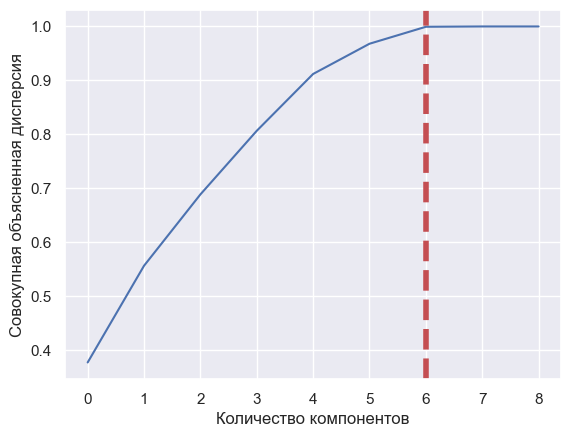

In [42]:
# Берём n_components за максимально возможный в нашем случае - 9.
pca_test = PCA(n_components=9)
pca_test.fit(X_train)

# Здесь мы взяли код, чтобы визуализировать на графике, с какого момента увелчение n_components не имеет смысла.
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Количество компонентов')
plt.ylabel('Совокупная объясненная дисперсия')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=6 , ymin=0, ymax=1)
plt.show()

Как мы можем заметить 7 компонентов более чем достаточно.
Воспользуемся этой информацией для уменьшения количества компонент вв выборке.

In [43]:
pca = PCA(n_components=7)
pca.fit(X_train)
X_train_scaled_pca = pca.transform(X_train)
X_test_scaled_pca = pca.transform(X_train)

Теперь попробуем посмотреть, изменилось ли что-то в качестве работы алгоритма (скорее всего нет).

In [55]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
rfc.score(X_train_scaled_pca, y_train)

0.7073446327683616

Изменений и правда нет, зато алгоритм стал оптимальнее.
Далее попробуем улучшить его работу с помощью оптимизации гиперпараметров, сначала с помощью RandomizedSearchCV.

In [50]:
# Заранее можем сказать, что результат вышел следующий:
# 'n_estimators': 600
# 'min_samples_split': 32
# 'min_samples_leaf': 17
# 'max_features': 'sqrt'
# 'max_depth': 11
# 'bootstrap': True

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 100, num = 20)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 100, num = 20)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

rs = RandomizedSearchCV(rfc,
                        param_dist,
                        n_iter = 100,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=0)
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 32,
 'min_samples_leaf': 17,
 'max_features': 'sqrt',
 'max_depth': 11,
 'bootstrap': True}

Соберём ввывводы в датасет и попробуем визуализировать лучшие параметры.

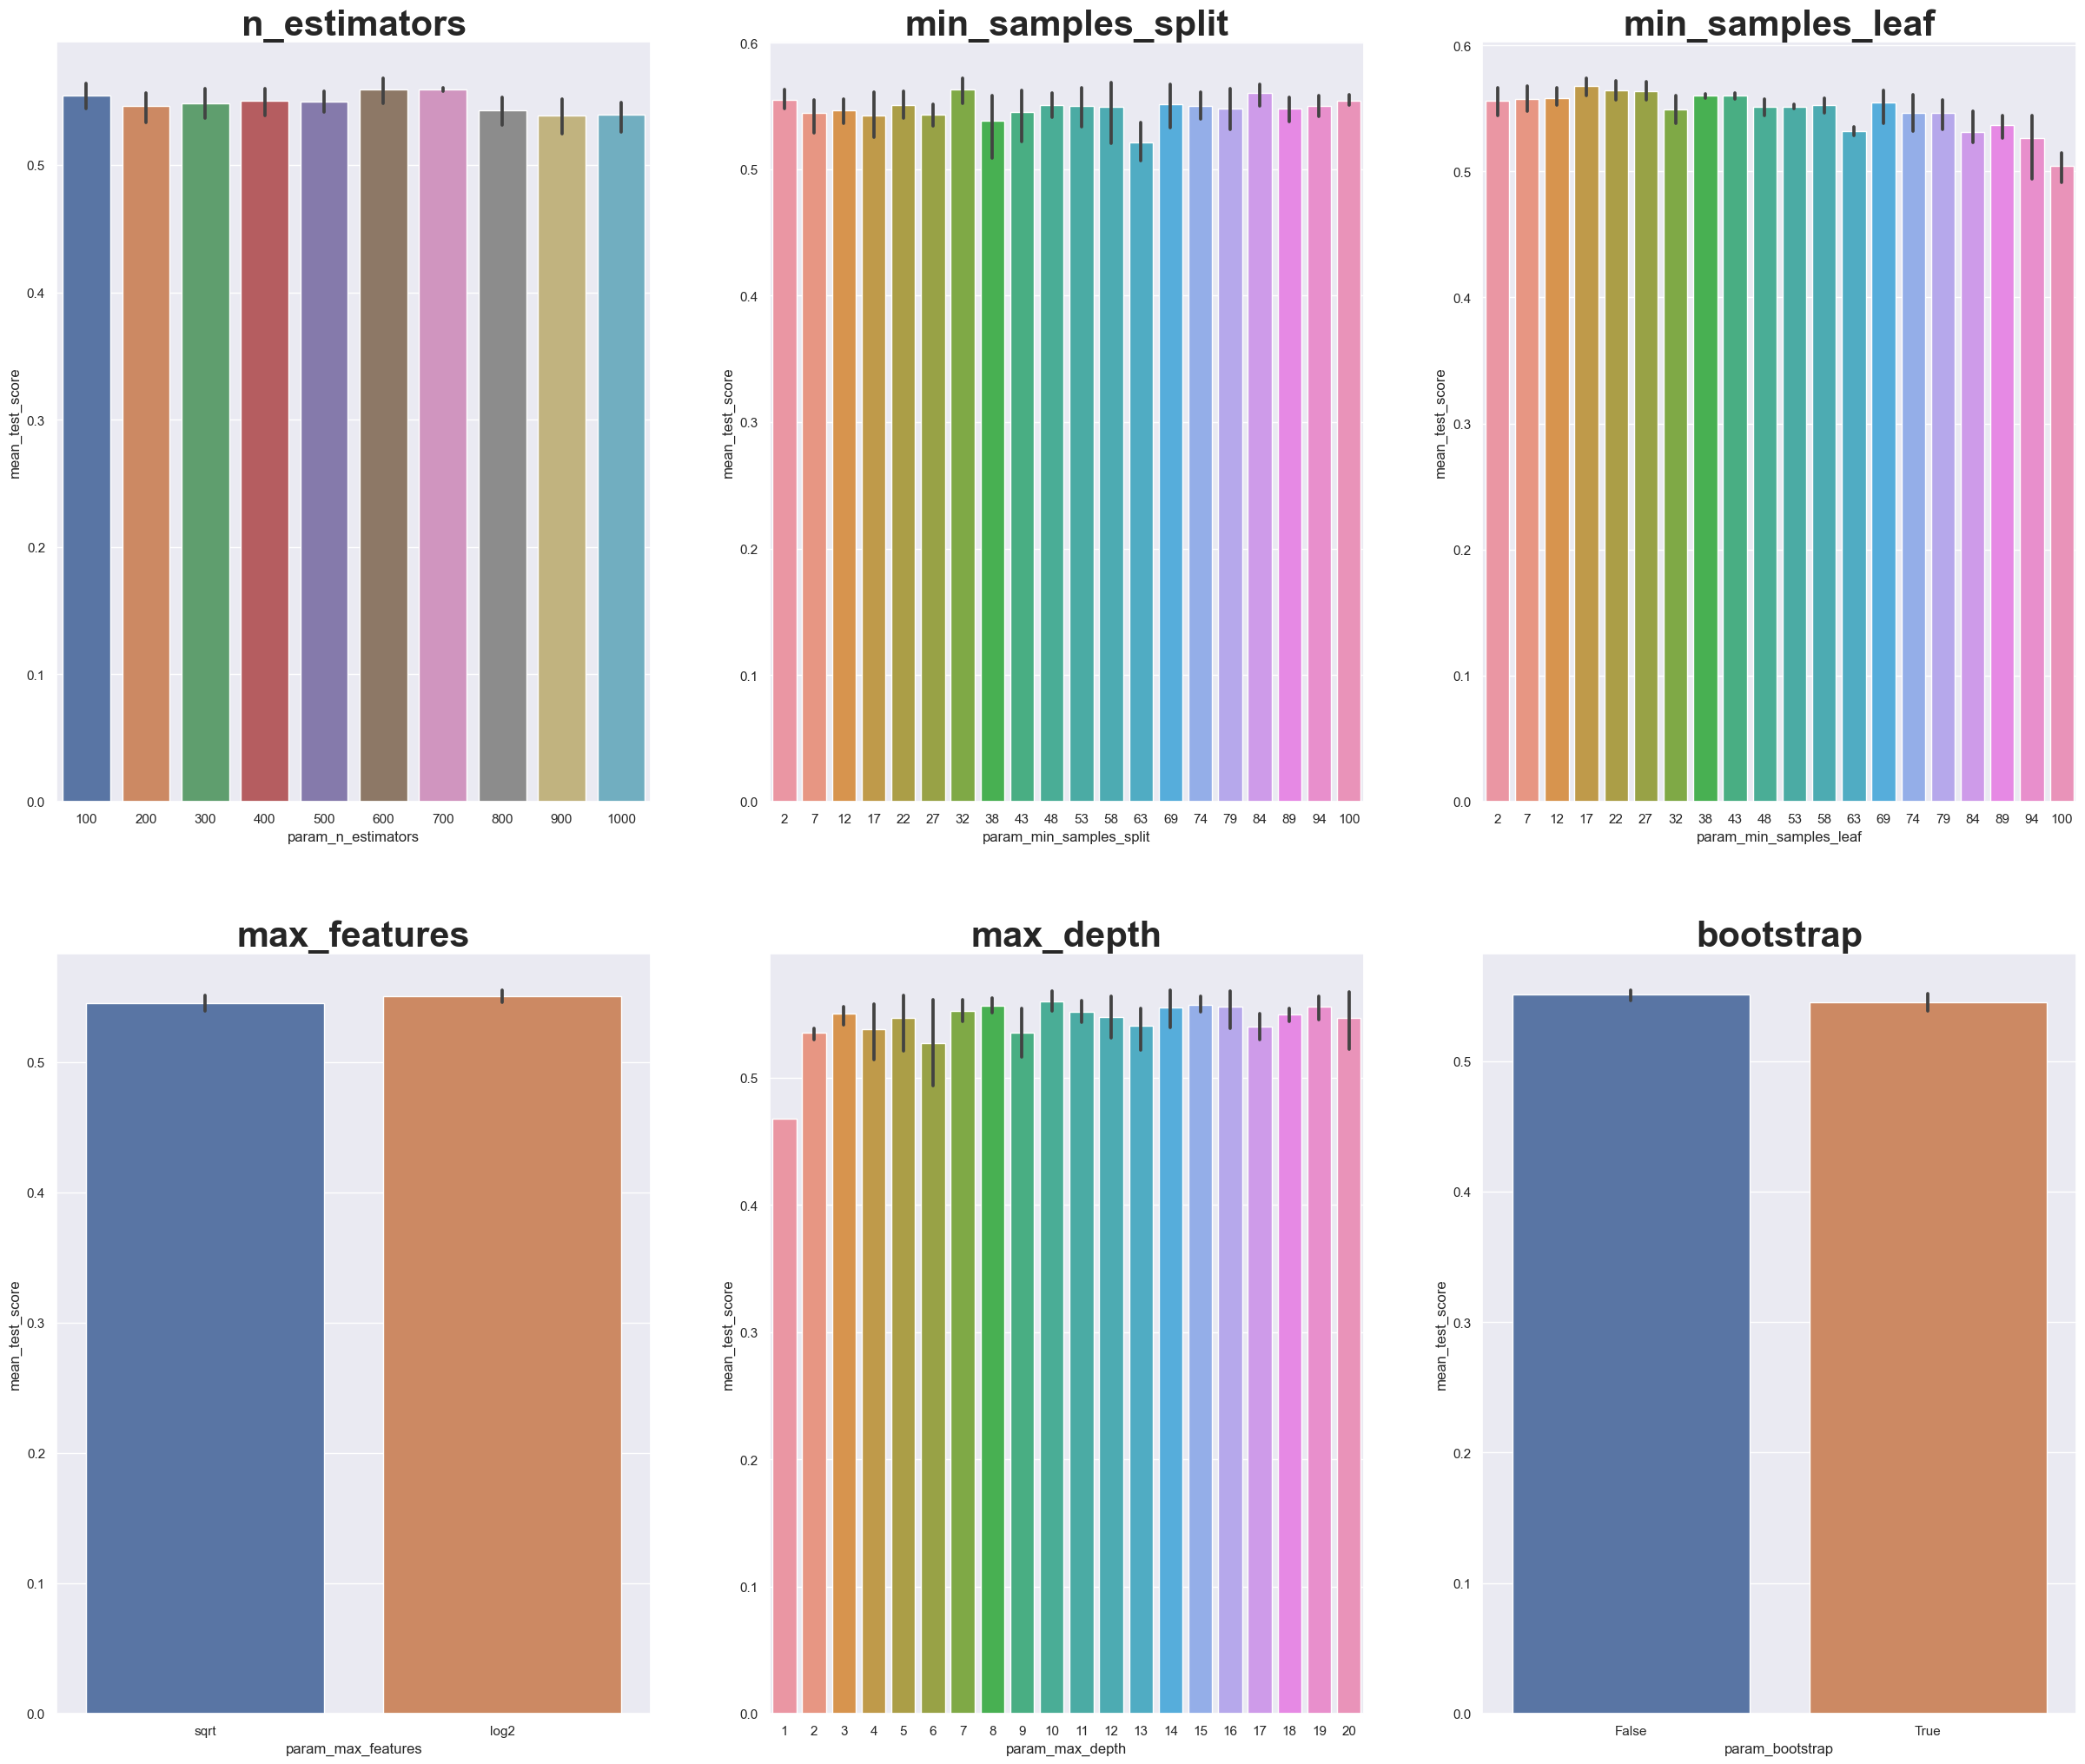

In [51]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
    'mean_fit_time',
    'std_fit_time',
    'mean_score_time',
    'std_score_time',
    'params',
    'split0_test_score',
    'split1_test_score',
    'split2_test_score',
    'std_test_score'],
    axis=1)

fig, axs = plt.subplots(ncols=3, nrows=2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

Как можно заметить, по параметрам в целом роли не игрaет...

Но можно выделить ряд лучших:
n_estimators = 100, 600, 700 дают лучшие результаты
min_sample_split = 2, 32, 84 дают неплохие результаты.
min_sample_leaf = 17 похоже даёт наилучший результат
max_features = log2 похоже немного опережает sqrt
max_depth = 8, 10, 15, 18 кажутся лучше других
bootstrap = False похоже немного опережает True

Попробуем теперь прогнать GridSearchCV по выделенным параметрам.
Так же включим и те, которые порекомендовала предыдущая система, если в наш обзор на глаз они не вошли.

In [52]:
# Заранее можем сказать, что результат вышел следующий:
# 'bootstrap': True
# 'max_depth': 11
# 'max_features': 'log2'
# 'min_samples_leaf': 17
# 'min_samples_split': 2
# 'n_estimators': 100

rfc = RandomForestClassifier()

n_estimators = [100, 600, 700]
min_samples_split = [2, 32, 84]
min_samples_leaf = [17]
max_features = ['log2']
max_depth = [8, 10, 11, 15, 18]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

gs = GridSearchCV(rfc, param_dist, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled_pca, y_train)
gs.best_params_

Fitting 3 folds for each of 90 candidates, totalling 270 fits


{'bootstrap': True,
 'max_depth': 11,
 'max_features': 'log2',
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'n_estimators': 100}

Вот и наши результаты, давайте попробуем их применить.

In [54]:
rfc_better = RandomForestClassifier(n_estimators=100, min_samples_split=17,
                             min_samples_leaf=2, max_features='log2',
                             max_depth=11, bootstrap=True)
rfc_better.fit(X_train_scaled_pca, y_train)
rfc_better.score(X_train_scaled_pca, y_train)

0.6519774011299435

Кажется, что качество ухудшилось, упало с 0.70 до 0.65... Попробуем воспользоваться матрицей и сравнить с оригинальной моделью.

In [61]:
y_pred_gs = gs.best_estimator_.predict(X_test_scaled_pca)
conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
                                     index = ['actual 0', 'actual 1', 'actual 3', 'actual 6'],
                                     columns = ['predicted 0', 'predicted 1', 'predicted 3', 'predicted 6'])
display("Модель с подобранными параметрами")
display(conf_matrix_tuned_pca)

y_pred_pca = rfc.predict(X_test_scaled_pca)
conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca),
                                        index = ['actual 0', 'actual 1', 'actual 3', 'actual 6'],
                                        columns = ['predicted 0', 'predicted 1', 'predicted 3', 'predicted 6'])

display("Модель со стандартными параметрами")
display(conf_matrix_baseline_pca)

'Модель с подобранными параметрами'

,predicted 0,predicted 1,predicted 3,predicted 6
actual 0,82,150,31,0
actual 1,102,253,59,0
actual 3,47,105,23,0
actual 6,8,17,8,0


'Модель со стандартными параметрами'

,predicted 0,predicted 1,predicted 3,predicted 6
actual 0,81,142,37,3
actual 1,97,244,68,5
actual 3,46,99,28,2
actual 6,5,17,10,1


Вот теперь понятна причина такого поведения точности модели. После подбора параметров модель действительно перекашивает и она действительно начинает склоняться в сторону того, что на вакансии требуется один год опыта, снижая шансы всех других вариантов.

Среди причин такого поведения мы можем назвать несколько моментов:
1. Довольно малое разнообразие в выборке, большая часть вакансий действительно требует опыт от года.
2. Большую часть вакансий составляют менеджеры по продажам, данная область труда имеет много специфических моментов, которые так же перекашиввают модель.
3. Очень мало категоризирующих данных. Категорий с достаточным объёмом признаков очень мало, как и самих признаков, что затрудняет обучение модели.
4. В данных может быть довольно много выбросов и просто странных вакансий.

Однако, несмотря на эти значительные проблемы, модель со своей задачей более-менее справляется. Даже если требуемый к вакансии опыт 6 лет, модель сопосбна понять, что там нужен минимум 1 год опыта.
Впрочем, весьма парадоксально, что при этом модель со стандартными параметрами справляется лучше.